# Optimizing trayectories of Omnibot

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from numpy import logical_and as npand
from numpy import logical_or as npor

In [2]:
from sympy import (symbols, pi, I, E, cos, sin, exp, tan, simplify, expand, factor, collect,
                   apart, cancel, expand_trig, diff, Derivative, Function, integrate, limit,
                   series, Eq, solve, dsolve, Matrix, N, preorder_traversal, Float, solve_linear_system,
                   eye, zeros, lambdify)
from sympy.physics.mechanics import dynamicsymbols, init_vprinting

In [3]:
init_vprinting()

### Using the symbolic formulas to generate the numeric model

In [4]:
def generic_omnibot_mats(n = 4, null_beta = True, equal_r = True):
    t, r, d, s = symbols('t r d s')
    alpha, beta= dynamicsymbols('alpha beta')
    
    W = Matrix([
        [r, cos(alpha)],
        [0, sin(alpha)]
    ])
    T = Matrix([
        [cos(beta), -sin(beta)],
        [sin(beta), cos(beta)]
    ])
    A = Matrix([
        [1, 0, -d],
        [0, 1, s]
    ])
    WTA= W.inv()@T.inv()@A
    WTA.simplify()
    r_n = WTA[0,:]
    s_n = WTA[1,:]
    
    R_list = []
    S_list = []
    
    for ii in range(n):
        r_ii = r_n.subs(alpha, symbols('alpha_'+str(ii+1)))
        r_ii = r_ii.subs(d, symbols('d_'+str(ii+1)))
        r_ii = r_ii.subs(s, symbols('s_'+str(ii+1)))
        s_ii = s_n.subs(alpha, symbols('alpha_'+str(ii+1)))
        s_ii = s_ii.subs(d, symbols('d_'+str(ii+1)))
        s_ii = s_ii.subs(s, symbols('s_'+str(ii+1)))
        if not equal_r:
            r_ii = r_ii.subs(r, symbols('r_'+str(ii+1)))
            s_ii = s_ii.subs(r, symbols('r_'+str(ii+1)))
        if null_beta:
            r_ii = r_ii.subs(beta, 0)
            s_ii = s_ii.subs(beta, 0)
        else:
            r_ii = r_ii.subs(beta, symbols('beta_'+str(ii+1)))
            s_ii = s_ii.subs(beta, symbols('beta_'+str(ii+1)))
            
        S_list.append(s_ii)
        R_list.append(r_ii)
    
    R = Matrix(R_list)
    S = Matrix(S_list)
    return R, S

In [5]:
def integerize(expr):
    expr2 = expr
    for a in preorder_traversal(expr):
        if isinstance(a, Float):
            expr2 = expr2.subs(a, round(a))
    return expr2

def roundize(expr,n = 4):
    expr2 = expr
    for a in preorder_traversal(expr):
        if isinstance(a, Float):
            expr2 = expr2.subs(a, round(a,n))
    return expr2

In [6]:
def dejabot_mats():
    R, S = generic_omnibot_mats()
    L, l = symbols('L l')
    for ii in range(4):
        alpha = pi/4 * (1 - 2 * ((int((ii+1)/2))%2))
        s = L * (1 - 2 * ((int((ii)/2))%2))
        d = l * (1 - 2 * (ii%2))
        R[ii,:] = R[ii,:].subs(symbols('alpha_'+str(ii+1)), alpha)
        R[ii,:] = R[ii,:].subs(symbols('s_'+str(ii+1)), s)
        R[ii,:] = R[ii,:].subs(symbols('d_'+str(ii+1)), d)
        S[ii,:] = S[ii,:].subs(symbols('alpha_'+str(ii+1)), alpha)
        S[ii,:] = S[ii,:].subs(symbols('s_'+str(ii+1)), s)
        S[ii,:] = S[ii,:].subs(symbols('d_'+str(ii+1)), d)
    return integerize(R), integerize(S)

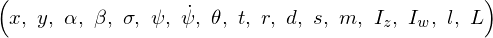

In [7]:
t, r, d, s, m, I_z, I_w, l, L = symbols('t r d s m I_z I_w l L')
x, y, alpha, beta, sigma, psi, theta= dynamicsymbols('x y alpha beta sigma psi theta')
psi_dot = psi.diff()
x, y, alpha, beta, sigma, psi, psi_dot, theta, t, r, d, s, m, I_z, I_w, l, L

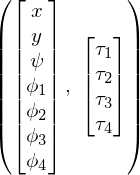

In [8]:
q = [x, y, psi] + [dynamicsymbols(f'phi_{i+1}') for i in range(4)]
q = Matrix(q)
Gamma = [dynamicsymbols(f'tau_{i+1}') for i in range(4)]
Gamma = Matrix(Gamma)

q, Gamma

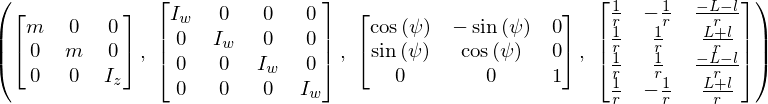

In [9]:
M_w = eye(4)*I_w
M_r = Matrix([
    [m, 0, 0],
    [0, m, 0],
    [0, 0, I_z]
])
R_psi = Matrix([
    [cos(psi), -sin(psi), 0],
    [sin(psi), cos(psi), 0],
    [0, 0, 1]
])
R, S = dejabot_mats()

M_r, M_w, R_psi, R

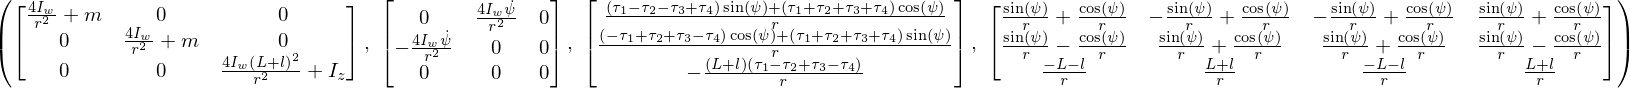

In [10]:
H = M_r + R_psi@R.T@M_w@R@R_psi.T
H = simplify(H)
K = R_psi@R.T@M_w@R@R_psi.diff().T
K = simplify(K)
F_a = R_psi@R.T@Gamma
F_a_0 = F_a[0].factor(sin(psi), cos(psi))
F_a_1 = F_a[1].factor(sin(psi), cos(psi))
F_a_2 = F_a[2].factor()
F_a = Matrix([F_a_0, F_a_1, F_a_2])
A = R_psi@R.T
H_inv = simplify(H.inv())
H, K, F_a, A

In [11]:
get_h_raw = lambdify([m, I_w, I_z, l, L, r], H)
get_k_raw = lambdify([I_w, r, psi_dot], K)
get_a_raw = lambdify([psi, l, L, r], A)
get_h_inv_raw = lambdify([m, I_w, I_z, l, L, r], H_inv)

## Electric Motor Model

$$ V = K_m \dot{\phi} + Ri$$
$$ \tau_m = K_ei - \tau_r$$

In [12]:
def friction(a, b, phi_dot, V, eps_phi = 0.1):
    fric_wet = a * phi_dot
    fric_dry = np.where(npor(
        phi_dot>eps_phi,
        npand(
            np.abs(phi_dot)<=eps_phi,
            V > 0)
    ),b, 0)
    fric_dry = np.where(npor(
        phi_dot< -eps_phi,
        npand(
            np.abs(phi_dot)<=eps_phi,
            V < 0)
    ),-b, fric_dry)
    return fric_wet + fric_dry

In [13]:
def create_motor_model(i_7000 = 0.5):
    V = 24
    R = 24/13
    K_m = (V - R*i_7000)/(2 * np.pi*7000/60)
    t_rat = 4300*9.8/(100*1000)    #570*9.8/(100*1000)
    phi_rat = 0                    #5900*np.pi*2/60
    i_rat = (V - K_m*phi_rat)/R
    K_e = t_rat/(i_rat-i_7000)
    t_r = -t_rat + K_e * i_rat
    print(f'K_m = {K_m}, K_e = {K_e}, R = {R}, i_rat = {i_rat}, t_r = {t_r}')
    def motor_model(phi_dot, V = 24):
        i = (V - K_m*phi_dot)/R
        t = K_e * i - friction(0,t_r, phi_dot, V)
        p = t * phi_dot
        ef = p / (i * V)
        return t, i, p, ef
    def simp_motor_model(phi_dot, V = 24):
        i = (V - K_m*phi_dot)/R
        t = K_e * i - friction(0,t_r, phi_dot, V)
        return t
    return motor_model, simp_motor_model

K_m = 0.03148119753466062, K_e = 0.033712, R = 1.8461538461538463, i_rat = 13.0, t_r = 0.016855999999999982


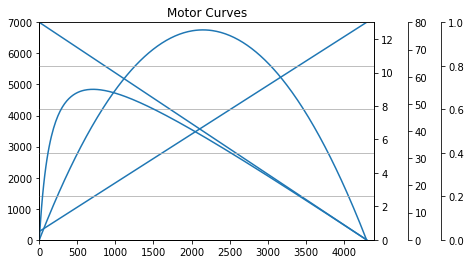

In [14]:
x = np.linspace(0, 2 * np.pi * 7000/60, 300)
n = x * 30 / np.pi
motor_model = create_motor_model(0.5)[0]
t, i, p, ef = motor_model(x)
t = t *100000/9.8

fig, ax1 = plt.subplots()

ax1.plot(t,n)
ax1.set_ylim([0,7000])
ax1.set_xlim([0,4400])

ax2 = ax1.twinx()
ax2.plot(t,i)
ax2.set_ylim([0,13])

ax3 = ax1.twinx()
ax3.plot(t,p)
ax3.spines["right"].set_position(("axes", 1.1))
ax3.set_ylim([0,80])

ax4 = ax1.twinx()
ax4.plot(t,ef)
ax4.spines["right"].set_position(("axes", 1.2))
ax4.set_ylim([0,1])
plt.grid()
plt.title('Motor Curves')

plt.grid(True)

### Comparison with manufacturer original motor curves:
![Original curves](images_dejabot/curvas_motor.png)

Expanded curves outside normal regime:

K_m = 0.03148119753466062, K_e = 0.033712, R = 1.8461538461538463, i_rat = 13.0, t_r = 0.016855999999999982


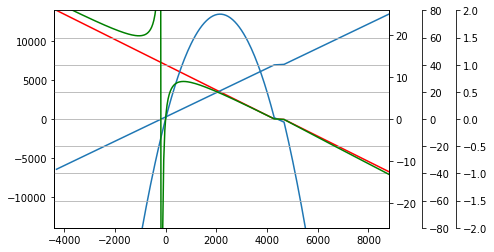

In [15]:
x = np.linspace(-2 * np.pi * 7000/60, 4 * np.pi * 7000/60, 300)
n = x * 30 / np.pi
motor_model = create_motor_model(0.5)[0]
t, i, p, ef = motor_model(x)
t = t *100000/9.8

fig, ax1 = plt.subplots()

ax1.plot(t,n, 'r')
ax1.set_ylim([-14000,14000])
ax1.set_xlim([-4400,8800])

ax2 = ax1.twinx()
ax2.plot(t,i)
ax2.set_ylim([-26,26])

ax3 = ax1.twinx()
ax3.plot(t,p)
ax3.spines["right"].set_position(("axes", 1.1))
ax3.set_ylim([-80,80])

ax4 = ax1.twinx()
ax4.plot(t,ef, 'g')
ax4.spines["right"].set_position(("axes", 1.2))
ax4.set_ylim([-2,2])
plt.grid()

plt.grid(True)

Adapted Curves with reductor gears:

In [16]:
def create_motoreduct_model(i_7000 = 0.5, N = 49, eff = 0.6, a = 0.01, b = 0.4):
    V = 24
    R = 24/13
    K_m = (V - R*i_7000)/(2 * np.pi*7000/60)
    t_rat = 4300*9.8/(100*1000)    #570*9.8/(100*1000)
    phi_rat = 0                    #5900*np.pi*2/60
    i_rat = (V - K_m*phi_rat)/R
    K_e = t_rat/(i_rat-i_7000)
    
    print(f'K_m = {K_m}, K_e = {K_e}, R = {R}, i_rat = {i_rat}')
    eps_phi = 0.1
    
    def motoreduct_model(phi_dot, V = 24):
        phi_dot_motor = phi_dot * N
        i = (V - K_m*phi_dot_motor)/R
        t = K_e * i * N * eff - friction(a, b, phi_dot, V, eps_phi)
        p = t * phi_dot
        ef = p / (i * V)
        return t, i, p, ef
    def simp_motoreduct_model(phi_dot, V = 24):
        phi_dot_motor = phi_dot * N
        i = (V - K_m*phi_dot_motor)/R
        t = K_e * i * N * eff - friction(a, b, phi_dot, V, eps_phi)
        return t
    return motoreduct_model, simp_motoreduct_model

K_m = 0.03148119753466062, K_e = 0.033712, R = 1.8461538461538463, i_rat = 13.0


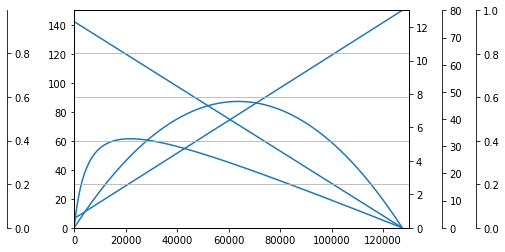

In [17]:
x = np.linspace(0, 2 * np.pi * 7000/(49*60), 300)
n = x * 30 / np.pi
motor_model = create_motoreduct_model(0.5)[0]
t, i, p, ef = motor_model(x)
t = t *100000/9.8

fig, ax1 = plt.subplots()

ax1.plot(t,n)
ax1.set_ylim([0,150])
ax1.set_xlim([0,130000])

ax2 = ax1.twinx()
ax2.plot(t,i)
ax2.set_ylim([0,13])

ax3 = ax1.twinx()
ax3.plot(t,p)
ax3.spines["right"].set_position(("axes", 1.1))
ax3.set_ylim([0,80])

ax4 = ax1.twinx()
ax4.plot(t,ef)
ax4.spines["right"].set_position(("axes", 1.2))
ax4.set_ylim([0,1])
#plt.grid()

ax5 = ax1.twinx()
ax5.spines["right"].set_position(("axes", -0.2))
ax5.set_ylim([0, x[-1]*0.0667])

plt.grid(True)

In [18]:
def torq_lims(phi_dot, v_max = 24, motor = create_motoreduct_model()[1]):
    t_max = motor(phi_dot, v_max)
    t_min = motor(phi_dot, -v_max)
    
    return t_max, t_min

K_m = 0.03148119753466062, K_e = 0.033712, R = 1.8461538461538463, i_rat = 13.0


In [19]:
def vect_torq_lims(geom, q, q_dot):
    a = get_a(geom, q)
    phi_dot = a.T@q_dot
    #print(f'phi_dot: {np.round(phi_dot,3)}')
    t_max = []
    t_min = []
    for wheel in phi_dot:
        maxt, mint = torq_lims(wheel)
        t_max.append(maxt)
        t_min.append(mint)
    t_max = np.array(t_max)
    t_min = np.array(t_min)
    
    return (t_max, t_min)

## Parameter encoding in functions:
$$Geom = [l, L, r]$$
$$Mass = [m, I_w,I_z]$$
$$q = [x, y, \psi]$$ where q is $q_r$

In [20]:
def get_h(geom, mass):
    l, L, r = geom
    m, I_w, I_z = mass
    return get_h_raw(m, I_w, I_z, l, L, r)

def get_k(geom, mass, q_dot):
    l, L, r = geom
    m, I_w, I_z = mass
    x_dot, y_dot, psi_dot = q_dot
    return get_k_raw(I_w, r, psi_dot)

def get_a(geom, q):
    l, L, r = geom
    x, y, psi = q
    return get_a_raw(psi, l, L, r)

def get_h_inv(geom, mass):
    l, L, r = geom
    m, I_w, I_z = mass
    return get_h_inv_raw(m, I_w, I_z, l, L, r)


In [21]:
geom = [0.2096, 0.2096, 0.0667]
mass = [15.75, 0.00266, 0.461]
q_0 = np.array([0, 0, 0])
q_dot_0 = np.array([0, 0, 0])
vect_torq_lims(geom, q_0, q_dot_0+[0.9,0,0])

(array([1.17529748, 1.17529748, 1.17529748, 1.17529748]),
 array([-24.59415532, -24.59415532, -24.59415532, -24.59415532]))

## Bot class creation

In [22]:
class Bot:
    def __init__(self, geom, mass, q_init, q_dot_init, u_func):
        self.geom = geom
        self.mass = mass
        self.q = q_init
        self.q_dot = q_dot_init
        self.get_u = u_func
        self.t = 0
        self.H = get_h(geom, mass)
        self.H_inv = get_h_inv(geom, mass)
        
    def get_a(self):
        return get_a(self.geom, self.q)
    
    def get_k(self):
        return get_k(self.geom, self.mass, self.q_dot)
    
    def vect_torq_lims(self):
        return vect_torq_lims(self.geom, self.q, self.q_dot)
    
    def max_q_sec_dir(self, alpha, beta, print_status = False):
        t_max, t_min = self.vect_torq_lims()
        A = self.get_a()
        B = np.linalg.pinv(A)
        q_sec = np.array([np.cos(alpha)*np.cos(beta), np.sin(alpha)*np.cos(beta),np.sin(beta)])
        v_1 = B@self.H@q_sec
        v_2 = B@self.get_k()@self.q_dot
        a_max = []
        for ii in range(4):
            a_1 = (t_max[ii]-v_2[ii])/v_1[ii]
            a_2 = (t_min[ii]-v_2[ii])/v_1[ii]
            a_max.append(max(a_1, a_2))
        if print_status:
            print(f'alpha = {np.round(alpha,3)}, \n\tv1 = {np.round(v_1,3)} \n\ta_max = {np.round(a_max,3)}')
        return min(a_max)
        
    
    def q_sec_lims(self):
        torq_lims = self.vect_torq_lims()
        q_sec_max = self.H_inv@(self.get_a()@torq_lims[0]-self.get_k()@self.q_dot)
        q_sec_min = self.H_inv@(self.get_a()@torq_lims[1]-self.get_k()@self.q_dot)
        return q_sec_max, q_sec_min
    
    def step(self, d_t, envir = None):
        u = self.get_u(self, d_t, envir)
        self.q = self.q + d_t * self.q_dot + 0.5 * u * d_t**2
        self.q_dot = self.q_dot + d_t * u
        self.t = self.t + d_t

In [23]:
geom = [0.2096, 0.2096, 0.0667]
mass = [15.75, 0.00266, 0.461]
q_0 = np.array([0, 0, 0])
q_dot_0 = np.array([0, 0, 0])
def dummy_u(bot, dt, envir):
    if envir:
        return(np.array(envir))
    #print(f't = {round(t,3)}, q = {q}, q_dot = {q_dot}')
    return(np.array([0,1,0]))
dejabot = Bot(geom, mass, q_0, q_dot_0, dummy_u)

## Bot class characteristics and capacities

q_dot: [0 0 0]
q: [0 0 0]


/Users/smorenom/anaconda3/envs/siro/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/Users/smorenom/anaconda3/envs/siro/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars


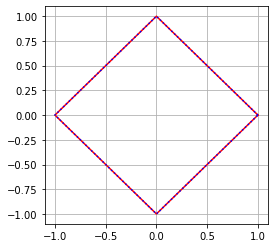

In [24]:
#dejabot.step(0.1)
print(f'q_dot: {dejabot.q_dot}\nq: {dejabot.q}')
x = np.linspace(0,1*2*np.pi, 401)
y = []
for ii in x:
    y.append(dejabot.max_q_sec_dir(ii, 0, False)/41.3)
y = np.array(y)
psi = dejabot.q[2]
w,h = plt.figaspect(1)
plt.figure(figsize = [w,h])
plt.plot(y*np.cos(x), y*np.sin(x), 'r')
plt.plot(y*np.cos(x-psi), y*np.sin(x-psi), 'b:')
plt.grid()

In [25]:
%matplotlib notebook

<IPython.core.display.Javascript object>


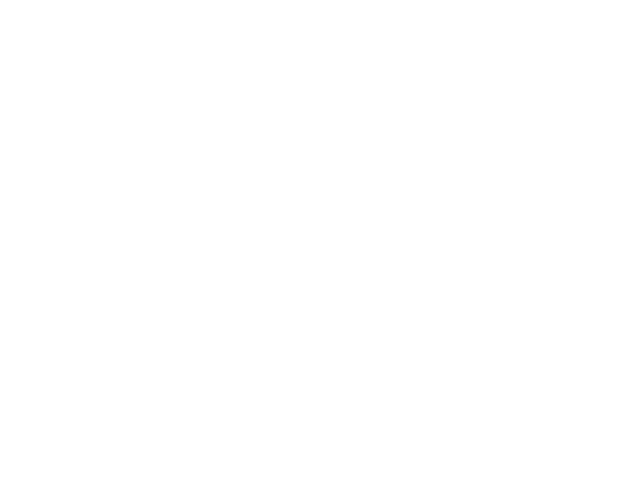

In [26]:
fig = plt.figure()
ax = plt.axes(projection="3d")

alpha = np.linspace(0,2*np.pi, 50)
beta = np.linspace(-np.pi,np.pi, 50)
dist = []
for aa in alpha:
    for bb in beta:
        dist.append([dejabot.max_q_sec_dir(aa, bb, False), aa,bb])
dist = np.array(dist)

z_points = dist[:,0] * np.sin(dist[:,2])
x_points = dist[:,0] * np.cos(dist[:,1]) * np.cos(dist[:,2])
y_points = dist[:,0] * np.sin(dist[:,1]) * np.cos(dist[:,2])
ax.scatter3D(x_points, y_points, z_points, s = 10);


In [27]:
%matplotlib inline

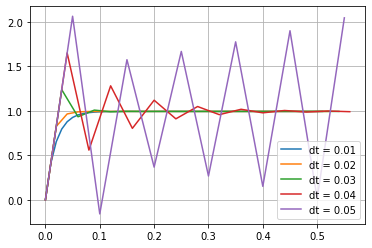

In [28]:
for dt in [0.01, 0.02, 0.03, 0.04, 0.05]:
    dejabot = Bot(geom, mass, q_0, q_dot_0, dummy_u)
    q_acum = [dejabot.q_dot[0],]
    for i in np.arange(0, 0.5+dt, dt):
        F = dejabot.max_q_sec_dir(np.pi/2, 0, False)
        dejabot.step(dt,[F,0,0])
        q_acum.append(dejabot.q_dot[0])
    q_acum = np.array(q_acum)
    plt.plot(np.arange(0, 0.5+ 2 *dt, dt), q_acum, label = 'dt = '+str(dt))
    #print(f'F: {F}\nq_dot: {dejabot.q_dot}\nq: {dejabot.q}')
plt.legend()
plt.grid()

In [29]:
def calc_alpha(q, goal):
    if abs(goal[0]-q[0])==0:
        alpha = np.pi/2
    else:
        alpha = np.arctan((goal[1]-q[1])/(goal[0]-q[0]))
    if (goal[0]-q[0]) < 0:
        alpha = alpha + np.pi
    return alpha

## Gradient Descent approach

In [30]:
goal = [0,1,0]
obstacles = []
envir = [goal, obstacles]
def simple_grad_desc(bot, dt, envir):
    q = bot.q
    goal, obstacles = envir
    alpha = calc_alpha(q, goal)
    a = bot.max_q_sec_dir(alpha, 0, False)
    u = [a*np.cos(alpha), a*np.sin(alpha),0]
    
    #print(f'alpha = {round(alpha,3)}, goal-q = {np.round(np.array(goal)-q,4)}, u = {np.round(u,4)}')
    
    return(np.array(u))

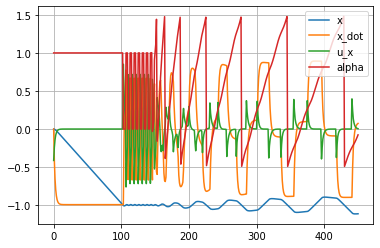

In [31]:
goal = [-1,0,0]
obstacles = []
envir = [goal, obstacles]
dt = 0.01
n = 450
dejabot = Bot(geom, mass, q_0, q_dot_0, simple_grad_desc)
x_acum = [dejabot.q[0],]
x_dot_acum = [dejabot.q[0],]
y_acum = [dejabot.q[1],]
u_hist = [dejabot.get_u(dejabot, dt, envir)]
alpha_hist = [calc_alpha(dejabot.q, goal)]
for i in range(n):
    dejabot.step(dt,envir)
    x_acum.append(dejabot.q[0])
    y_acum.append(dejabot.q[1])
    x_dot_acum.append(dejabot.q_dot[0])
    u_hist.append(dejabot.get_u(dejabot, dt, envir))
    alpha_hist.append(calc_alpha(dejabot.q, goal))
x_acum = np.array(x_acum)
y_acum = np.array(y_acum)
x_dot_acum = np.array(x_dot_acum)
u_hist = np.array(u_hist)
alpha_hist = np.array(alpha_hist)
plt.plot(np.arange(n+1), x_acum, label = 'x')
#plt.plot(np.arange(n+1), y_acum, label = 'y')
plt.plot(np.arange(n+1), x_dot_acum, label = 'x_dot')
plt.plot(np.arange(n+1), u_hist[:,0]*0.01, label = 'u_x')
plt.plot(np.arange(n+1), alpha_hist/np.pi, label = 'alpha')
plt.legend()
plt.grid()
#print(f'F: {F}\nq_dot: {dejabot.q_dot}\nq: {dejabot.q}')

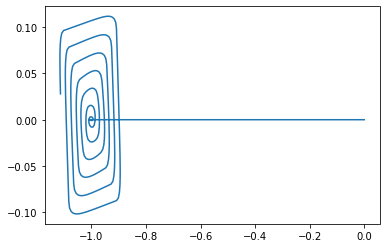

In [32]:
plt.plot(x_acum, y_acum)

In [33]:
def max_speed_dir(bot, alpha, max_motor_rpm = 7000, N = 49):
    A = bot.get_a()
    v = np.array([np.cos(alpha), np.sin(alpha),0])
    D = A.T@v
    b = []
    for ii in range(4):
        b_m = max_motor_rpm/(30*49*D[ii])
        b.append(abs(b_m))
    return min(b)

q_dot: [0 0 0]
q: [0 0 0]


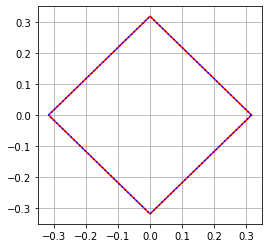

In [34]:
geom = [0.2096, 0.2096, 0.0667]
mass = [15.75, 0.00266, 0.461]
q_0 = np.array([0, 0, 0])
q_dot_0 = np.array([0, 0, 0])
def dummy_u(bot, dt, envir):
    if envir:
        return(np.array(envir))
    #print(f't = {round(t,3)}, q = {q}, q_dot = {q_dot}')
    return(np.array([0,1,0]))
dejabot = Bot(geom, mass, q_0, q_dot_0, dummy_u)

print(f'q_dot: {dejabot.q_dot}\nq: {dejabot.q}')
x = np.linspace(0,2*np.pi, 401)
y = []
for ii in x:
    y.append(max_speed_dir(dejabot, ii))
y = np.array(y)
psi = dejabot.q[2]
w,h = plt.figaspect(1)
plt.figure(figsize = [w,h])
plt.plot(y*np.cos(x), y*np.sin(x), 'r')
plt.plot(y*np.cos(x+psi), y*np.sin(x+psi), 'b:')
plt.grid()

In [35]:
goal = [0,1,0]
obstacles = []
envir = [goal, obstacles]
def better_grad_desc(bot, dt, envir, print_m = False):
    q = bot.q
    goal, obstacles = envir
    alpha = calc_alpha(q, goal)
    v_unit = np.array([np.cos(alpha), np.sin(alpha),0])
    max_speed = max_speed_dir(bot, alpha)
    dist = np.linalg.norm(np.matrix(goal)-q)
    
    one_step_speed = dist/dt
    speed = min(max_speed,  one_step_speed)
    q_dot = bot.q_dot
    delta_v = speed*v_unit - q_dot
    
    beta = calc_alpha([0,0,0], delta_v)
    max_acc = bot.max_q_sec_dir(beta, 0, False)
    one_step_accel = np.linalg.norm(delta_v)/dt
    accel = min(max_acc, one_step_accel)
    
    u = [accel*np.cos(beta), accel*np.sin(beta),0]
    if print_m:
        print(f'delta_v = {np.round(delta_v,4)}, beta = {np.round(beta*180/np.pi,4)}, a = {np.round(max_acc,4)} u = {np.round(u,4)}')
    
    return(np.array(u))

/Users/smorenom/anaconda3/envs/siro/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/Users/smorenom/anaconda3/envs/siro/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars


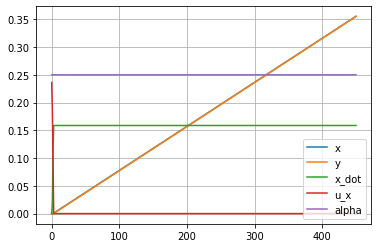

In [36]:
goal = [1,1,0]
obstacles = []
envir = [goal, obstacles]
dt = 0.005
n = 450
q_0 = np.array([0, 0, 0])
q_dot_0 = np.array([-0.1, -0.2, 0])
dejabot = Bot(geom, mass, q_0, q_dot_0, better_grad_desc)
x_acum = [dejabot.q[0],]
x_dot_acum = [dejabot.q[0],]
y_acum = [dejabot.q[1],]
u_hist = [dejabot.get_u(dejabot, dt, envir)]
alpha_hist = [calc_alpha(dejabot.q, goal)]
for i in range(n):
    dejabot.step(dt,envir)
    x_acum.append(dejabot.q[0])
    y_acum.append(dejabot.q[1])
    x_dot_acum.append(dejabot.q_dot[0])
    u_hist.append(dejabot.get_u(dejabot, dt, envir, False))
    alpha_hist.append(calc_alpha(dejabot.q, goal))
x_acum = np.array(x_acum)
y_acum = np.array(y_acum)
x_dot_acum = np.array(x_dot_acum)
u_hist = np.array(u_hist)
alpha_hist = np.array(alpha_hist)
plt.plot(np.arange(n+1), x_acum, label = 'x')
plt.plot(np.arange(n+1), y_acum, label = 'y')
plt.plot(np.arange(n+1), x_dot_acum, label = 'x_dot')
plt.plot(np.arange(n+1), u_hist[:,0]*0.01, label = 'u_x')
plt.plot(np.arange(n+1), alpha_hist/np.pi, label = 'alpha')
plt.legend()
plt.grid()

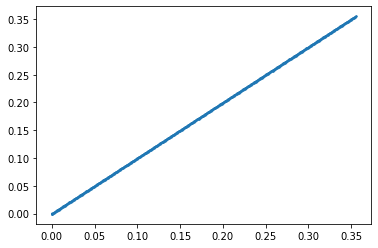

In [37]:
plt.plot(x_acum, y_acum, marker = '.', markersize = 3)

In [38]:
def calc_field_value(q, envir):
    goal, obstacles = envir
    x, y, psi = q
    z = ((goal[0]-x)**2 + (goal[1]-y)**2)**0.5
    for obs in obstacles:
        dist = ((obs[0]-x)**2 + (obs[1]-y)**2)**0.5
        z = z + np.where(dist <= obs[2], 2, 1.5/((dist - obs[2] + 0.025)*40)**4)
    return z

In [39]:
x = np.linspace(0,1,100)
y = x
xx,yy = np.meshgrid(x, y)
zz = calc_field_value([xx,yy,0], envir)

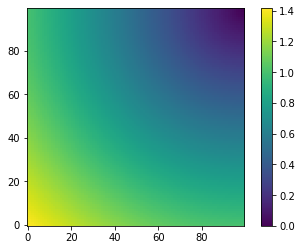

In [40]:
plt.imshow(zz, origin = 'lower')
plt.colorbar()

In [41]:
def first_der_grad_dir(q, ds, func, envir):
    x, y, psi = q
    dx = np.array([ds,0,0])
    dy = np.array([0,ds,0])
    dfx = func(q+dx, envir) - func(q, envir)
    dfy = func(q+dy, envir) - func(q, envir)
    #print (f'x:{x} dx: {dx} f(q){func(q, envir)} f(q+dx){func(q+dx, envir)} dfx: {dfx}')
    alpha = calc_alpha([0,0], [-dfx, -dfy])
    return alpha

In [42]:
goal = [1,1,0]
obstacles = [
    [0.5, 0.3, 0.1],
    [0, 0.6, 0.02]
]
envir = [goal, obstacles]
def better_grad_desc(bot, dt, envir, print_m = False):
    q = bot.q
    goal, obstacles = envir
    q_dot = bot.q_dot
    next_q = q + q_dot*dt #not taking on account acceleration, unknown at this point
    
    alpha = first_der_grad_dir(next_q, dt*0.005, calc_field_value, envir)
    v_unit = np.array([np.cos(alpha), np.sin(alpha),0])
    max_speed = max_speed_dir(bot, alpha)
    dist = np.linalg.norm(np.matrix(goal)-next_q)
    
    one_step_speed = dist/dt
    speed = min(max_speed,  one_step_speed)
    delta_v = speed*v_unit - q_dot
    
    beta = calc_alpha([0,0,0], delta_v)
    max_acc = bot.max_q_sec_dir(beta, 0, False)
    one_step_accel = np.linalg.norm(delta_v)/dt
    accel = min(max_acc, one_step_accel)
    
    u = [accel*np.cos(beta), accel*np.sin(beta),0]
    if print_m:
        print(f'delta_v = {np.round(delta_v,4)}, beta = {np.round(beta*180/np.pi,4)}, a = {np.round(max_acc,4)} u = {np.round(u,4)}')
    
    return(np.array(u))

/Users/smorenom/anaconda3/envs/siro/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/Users/smorenom/anaconda3/envs/siro/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars


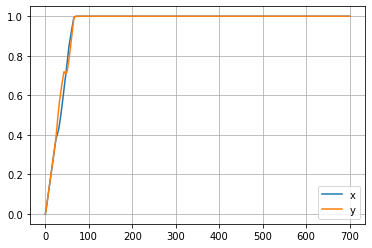

In [43]:
goal = [1,1,0]
obstacles = [
    [0.6, 0.4, 0.15],
    [0, 0.6, 0.02],
    [0.7, 0.85, 0.08]
]
envir = [goal, obstacles]
dt = 0.1
n = 700
q_0 = np.array([0, 0, 0])
q_dot_0 = np.array([0, 0, 0])
dejabot = Bot(geom, mass, q_0, q_dot_0, better_grad_desc)
x_acum = [dejabot.q[0],]
x_dot_acum = [dejabot.q[0],]
y_acum = [dejabot.q[1],]
u_hist = [dejabot.get_u(dejabot, dt, envir)]
alpha_hist = [first_der_grad_dir(dejabot.q, dt*0.005, calc_field_value, envir)]
for i in range(n):
    dejabot.step(dt,envir)
    x_acum.append(dejabot.q[0])
    y_acum.append(dejabot.q[1])
    x_dot_acum.append(dejabot.q_dot[0])
    #print('\nq = ', np.round(dejabot.q, 4),'q_dot = ', np.round(dejabot.q_dot, 4))
    u_hist.append(dejabot.get_u(dejabot, dt, envir, False))
    alpha_hist.append(calc_alpha(dejabot.q, goal))
x_acum = np.array(x_acum)
y_acum = np.array(y_acum)
x_dot_acum = np.array(x_dot_acum)
u_hist = np.array(u_hist)
alpha_hist = np.array(alpha_hist)
plt.plot(np.arange(n+1), x_acum, label = 'x')
plt.plot(np.arange(n+1), y_acum, label = 'y')
#plt.plot(np.arange(n+1), x_dot_acum, label = 'x_dot')
#plt.plot(np.arange(n+1), u_hist[:,0]*0.01, label = 'u_x')
#plt.plot(np.arange(n+1), alpha_hist/np.pi, label = 'alpha')
plt.legend()
plt.grid()

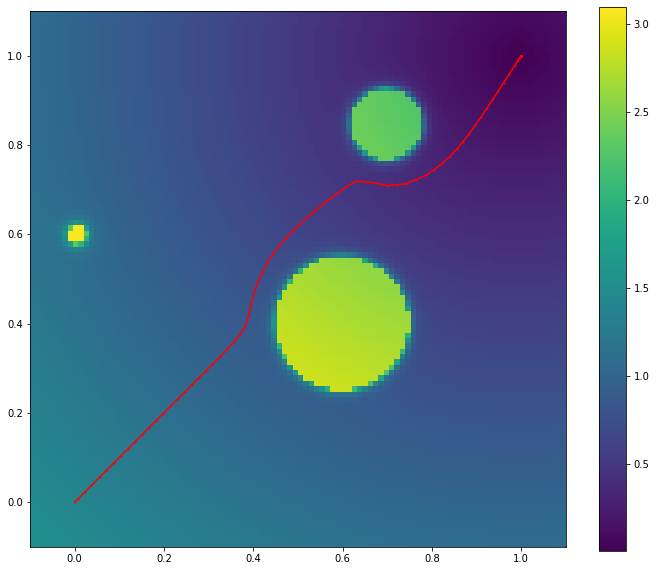

In [44]:
plt.figure(figsize = [12,10])
x = np.linspace(-0.1,1.1,100)
y = x
xx,yy = np.meshgrid(x, y)
zz = calc_field_value([xx,yy,0], envir)
plt.imshow(zz, extent=[-0.1,1.1,-0.1,1.1], origin = 'lower')
plt.plot(x_acum, y_acum,'r', marker = '.', markersize = 2)
plt.colorbar()

## Simulation stop criteria

In [45]:
def stop_cond_pos(bot, envir, eps_q = 0.001, eps_q_dot = 0.1):
    q = bot.q
    goal, obstacles = envir
    q_dot = bot.q_dot
    
    c1 = np.linalg.norm(np.matrix(goal)-q)
    c2 = np.linalg.norm(q_dot)
    
    #print(f'c1 = {c1}, c2 = {c2}')
    if c1<eps_q and c2<eps_q_dot:
        return True
    else:
        return False    

In [46]:
def simulation(bot, envir, dt = 0.01, n = 1000,
               q_0 = np.array([0, 0, 0]), q_dot_0 = np.array([0, 0, 0]),
               print_u = False, print_state = False):
    x_acum = [bot.q[0],]
    x_dot_acum = [bot.q[0],]
    y_acum = [bot.q[1],]
    u_hist = [bot.get_u(bot, dt, envir)]
    alpha_hist = [first_der_grad_dir(bot.q, dt*0.005, calc_field_value, envir)]
    for i in range(n):
        bot.step(dt,envir)
        x_acum.append(bot.q[0])
        y_acum.append(bot.q[1])
        x_dot_acum.append(bot.q_dot[0])
        if print_state:
            print('\nq = ', np.round(bot.q, 4),'q_dot = ', np.round(bot.q_dot, 4))
        u_hist.append(bot.get_u(bot, dt, envir, print_u))
        alpha_hist.append(calc_alpha(bot.q, goal))
        if stop_cond_pos(bot, envir):
            break
    x_acum = np.array(x_acum)
    y_acum = np.array(y_acum)
    x_dot_acum = np.array(x_dot_acum)
    u_hist = np.array(u_hist)
    alpha_hist = np.array(alpha_hist)
    
    return x_acum, y_acum, x_dot_acum, u_hist, alpha_hist

/Users/smorenom/anaconda3/envs/siro/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/Users/smorenom/anaconda3/envs/siro/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars


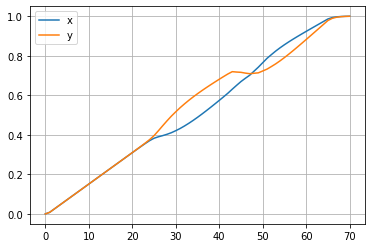

In [47]:
goal = [1,1,0]
obstacles = [
    [0.6, 0.4, 0.15],
    [0, 0.6, 0.02],
    [0.7, 0.85, 0.08]
]
envir = [goal, obstacles]
dt = 0.1
n = 1000
q_0 = np.array([0, 0, 0])
q_dot_0 = np.array([0, 0, 0])
dejabot = Bot(geom, mass, q_0, q_dot_0, better_grad_desc)

results = simulation(dejabot, envir, dt, n, q_0, q_dot_0, print_u = False, print_state = False)
x_acum, y_acum, x_dot_acum, u_hist, alpha_hist = results

plt.plot(np.arange(len(x_acum)), x_acum, label = 'x')
plt.plot(np.arange(len(x_acum)), y_acum, label = 'y')
#plt.plot(np.arange(n+1), x_dot_acum, label = 'x_dot')
#plt.plot(np.arange(n+1), u_hist[:,0]*0.01, label = 'u_x')
#plt.plot(np.arange(n+1), alpha_hist/np.pi, label = 'alpha')
plt.legend()
plt.grid()

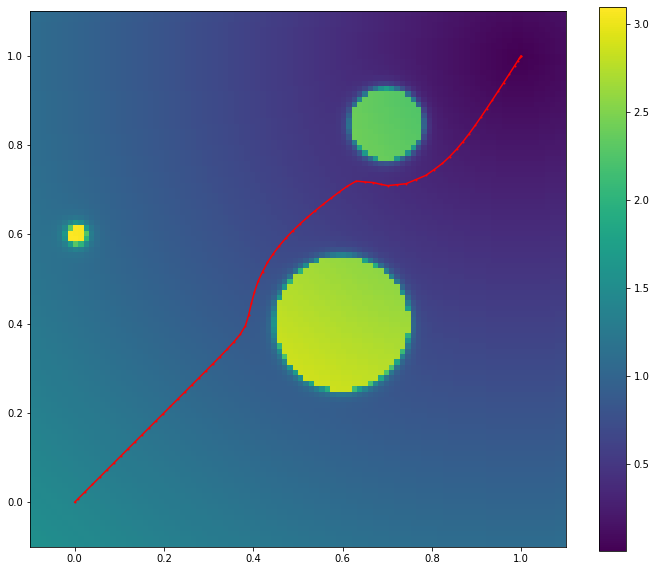

In [48]:
plt.figure(figsize = [12,10])
x = np.linspace(-0.1,1.1,100)
y = x
xx,yy = np.meshgrid(x, y)
zz = calc_field_value([xx,yy,0], envir)
plt.imshow(zz, extent=[-0.1,1.1,-0.1,1.1], origin = 'lower')
plt.plot(x_acum, y_acum,'r', marker = '.', markersize = 2)
plt.colorbar()